In [1]:
import pandas as pd 
import numpy as np 

In [21]:
import re
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import Input,Embedding,Bidirectional,LSTM,BatchNormalization,Dense,Dropout
import keras
import matplotlib.pyplot as plt

In [2]:
tweet_data = pd.read_csv('Tweets.csv')
print("data shape:",tweet_data.shape)
print("what are columns:",tweet_data.columns)
tweet_data.head()

data shape: (14640, 15)
what are columns: Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
data=tweet_data[['text','airline_sentiment']]

In [5]:
data.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [14]:
stopwords = stopwords.words("english")

In [7]:
def remove_mentions(text):
    reduced=re.sub(r'@\w+','',text)
    return reduced

In [8]:
def remove_links(text):
    reduced = re.sub(r'http\S+', '', text)
    return reduced

In [9]:
def remove_hashtags(text):
    reduced=re.sub(r'#','',text)
    return reduced

In [10]:
def remove_punctuation(text):
    reduced = re.sub(r'[.,!?;-]', '',text)
    return reduced


In [11]:
def remove_stopwords(text):
    text = text.split()
    text = [word for word in text if word not in stopwords]
    text = " ".join(text)
    return text

In [12]:
def remove_simbol(text):
    reduced=re.sub(r'"','',text)
    return reduced

In [13]:
def clean(text):
    text = text.lower()
    text = remove_links(text)
    text = remove_mentions(text)
    text = remove_hashtags(text)
    text = remove_simbol(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    
    return text

In [15]:
data.text=data.text.apply(clean)

/home/ruiite/.virtualenvs/ds/lib64/python3.9/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.text)

In [17]:
counts = tokenizer.word_counts
print(len(counts))

14879


In [18]:
total_freq = 0
rare_freq = 0
rare_counts = 0
thread=2

for key,value in counts.items():
    total_freq += value
    if value<thread:
        rare_freq += value
        rare_counts += value

print(f"{rare_counts} are used less than {thread} times")
print(f"And these words accounts for {np.round(rare_freq/total_freq*100,2)}% of whole texts")

8422 are used less than 2 times
And these words accounts for 6.03% of whole texts


In [19]:
word_size=(14834-8422)
vocab_size = word_size+1
tokenizer = Tokenizer(num_words=word_size)

tokenizer.fit_on_texts(data.text)
tokenized = tokenizer.texts_to_sequences(data.text)

print("\nSamples\n")
print(tokenized[0])
print(tokenized[1])
print(len(tokenized))


Samples

[135]
[448, 1041, 2389, 117]
14640


Average length of each row >> 8.955464480874317
Maximum length of each row >> 22


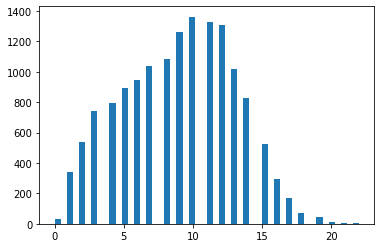

In [22]:
lengths = [len(s) for s in tokenized]
print(f"Average length of each row >> {np.mean(lengths)}")
print(f"Maximum length of each row >> {np.max(lengths)}")

plt.hist(lengths,bins=50)
plt.show()

In [23]:
sequence_size = 20

In [24]:
padded = pad_sequences(tokenized,maxlen=sequence_size,padding='post',truncating='post')
print(padded.shape)
print("Padded samples")
print(padded[0])
print(padded[1])

(14640, 20)
Padded samples
[135   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
[ 448 1041 2389  117    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [25]:
data.airline_sentiment.replace(['negative','neutral','positive'],[-1,0,1],inplace=True)

label = to_categorical(data.airline_sentiment,num_classes=3)

/home/ruiite/.virtualenvs/ds/lib64/python3.9/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [28]:
label.shape

(14640, 3)

In [29]:
train_data,test_data,train_label,test_label = train_test_split(padded,label,test_size=0.2,stratify=label,random_state=42)


In [30]:
word_vec_size=100
hidden_size=256

def create_lstm():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size)(X)
    
    H = BatchNormalization()(H)
    H = LSTM(hidden_size,return_sequences=True)(H)
    H = BatchNormalization()(H)
    H = LSTM(int(hidden_size/2),return_sequences=True)(H)
    H = BatchNormalization()(H)
    H = LSTM(int(hidden_size/4))(H)
    

    H = Dropout(0.2)(H)

    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [31]:
lstm_no = create_lstm()
lstm_no_hist = lstm_no.fit(train_data,train_label,epochs=4,batch_size=64,validation_split=0.2)
lstm_no.evaluate(test_data,test_label)

Epoch 1/4
147/147 [==============================] - 43s 162ms/step - loss: 0.7972 - accuracy: 0.6593 - val_loss: 1.2576 - val_accuracy: 0.2727
Epoch 2/4
147/147 [==============================] - 19s 129ms/step - loss: 0.4470 - accuracy: 0.8330 - val_loss: 0.7845 - val_accuracy: 0.6347
Epoch 3/4
147/147 [==============================] - 19s 133ms/step - loss: 0.3349 - accuracy: 0.8796 - val_loss: 0.6060 - val_accuracy: 0.7576
Epoch 4/4
92/92 [==============================] - 3s 28ms/step - loss: 0.6659 - accuracy: 0.7585


[0.6658557653427124, 0.7585382461547852]